In [1]:
# Imports
import os
import torch
import numpy as np

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils

In [2]:
# Specify directories
frame_folder = "./data/frames"

# Create Training and Test Sets

In [3]:
# Define label dictionary - 20 classes
syncs = [  "0-50 ms",   "51-100 ms", "101-150 ms", "151-200 ms", "201-250 ms",
         "251-300 ms", "301-350 ms", "351-400 ms", "401-450 ms", "451-500 ms", 
         "501-550 ms", "551-600 ms", "601-650 ms", "651-700 ms", "701-750 ms", 
         "751-800 ms", "801-850 ms", "851-900 ms", "901-950 ms", "951-1000 ms" ]
sync_dict = {}

count = 0
for sync_val in syncs:
    sync_dict[sync_val] = count
    count += 1

# preview dictionary
sync_dict

{'0-50 ms': 0,
 '51-100 ms': 1,
 '101-150 ms': 2,
 '151-200 ms': 3,
 '201-250 ms': 4,
 '251-300 ms': 5,
 '301-350 ms': 6,
 '351-400 ms': 7,
 '401-450 ms': 8,
 '451-500 ms': 9,
 '501-550 ms': 10,
 '551-600 ms': 11,
 '601-650 ms': 12,
 '651-700 ms': 13,
 '701-750 ms': 14,
 '751-800 ms': 15,
 '801-850 ms': 16,
 '851-900 ms': 17,
 '901-950 ms': 18,
 '951-1000 ms': 19}

In [4]:
# Construct X = folder names, y = the label

vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label)

# Display video count
len(X_paths), len(y)

Current Video: video1


(84, 84)

In [5]:
# Preview Data distribution
from collections import Counter
Counter(y)

Counter({10: 5,
         11: 4,
         16: 4,
         3: 7,
         0: 3,
         12: 4,
         18: 5,
         19: 5,
         4: 3,
         5: 4,
         6: 5,
         8: 4,
         9: 4,
         1: 3,
         2: 5,
         13: 2,
         14: 4,
         15: 4,
         17: 6,
         7: 3})

In [6]:
### To Implement when we have enough videos

# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.3, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("TEst Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (58,58)
TEst Set: (26,26)


In [7]:
# Temporary Training Set
#train_X_paths = X_paths
#train_ys = y

# Temporary Test Set - get a random video: # 18, 19
#test_X_paths = X_paths[18:20]
#test_ys = y[18:20]

#len(train_ys), len(test_ys)

# Create Pytorch Dataset

In [8]:
# Set seeds for reproducibility
#np.random.seed(2020)
#orch.manual_seed(2020)

In [9]:
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        #print(npz_path)
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # Transform if needed
        
        # Convert X to tensor
        X_tensor = torch.from_numpy(X_feat).float()
        
        # Convert y to one-hot encoding
        #encoding = np.zeros((1,20))
        #encoding[0, self.y[idx]] = 1
        
        # Convert to tensor
        #y_tensor = torch.tensor(self.y[idx]).long()
        
        return X_tensor, self.y[idx] # y_tensor

In [10]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    transforms.ToTensor() # Add min-max scaler, or an normalizer
])

In [11]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)
print(len(testing_dataset))

58
26


In [12]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

# Define Data Loader  

Data Loader for extracting batches from the Pytorch Dataset during model training

In [13]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch)
    
    return X_tensor, y_tensor

In [14]:
# Specify batch size
batch_size = 20

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

In [15]:
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([20, 20, 168]) torch.Size([20])
torch.Size([20, 20, 168]) torch.Size([20])


# Model Definition 

In [16]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        return output
        

In [17]:
# RNN Model Parameters
model_params = {
    "num_classes": 20,
    "dr_rate": 0.1,
    "rnn_num_layers": 2,
    "rnn_hidden_size": 200,
}
model = SyncRNN(model_params)

In [18]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.zeros(1, 20, 168)
    y = model(x)
    print(y.shape) # should be [1,20]

torch.Size([1, 1, 20])


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Print Model Params
model = model.to(device)
model

cuda:0


SyncRNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): LSTM(168, 200, num_layers=2)
  (fc1): Linear(in_features=200, out_features=20, bias=True)
)

# Model Training  

Define loss function and optimizer to train the model

In [20]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(reduction="sum")

In [21]:
# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 3e-3) #3e-5 # 3e-3

In [22]:
# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

In [23]:
# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 20,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights.pt",
}

In [24]:
trained_model, loss_hist, metric_hist = trainutils.train_model(model, train_params)

Epoch 0/19, current_lr=0.003



Saved best model weights
Train Loss: 3.056348, Dev Loss: 2.984523, Accuracy: 7.69
----------
Epoch 1/19, current_lr=0.003



Saved best model weights
Train Loss: 3.012006, Dev Loss: 2.982533, Accuracy: 3.85
----------
Epoch 2/19, current_lr=0.003



Train Loss: 2.974848, Dev Loss: 2.999580, Accuracy: 7.69
----------
Epoch 3/19, current_lr=0.003



Train Loss: 2.946735, Dev Loss: 2.997999, Accuracy: 7.69
----------
Epoch 4/19, current_lr=0.003



Train Loss: 2.944391, Dev Loss: 2.997502, Accuracy: 7.69
----------
Epoch 5/19, current_lr=0.003



Train Loss: 2.936156, Dev Loss: 3.001898, Accuracy: 7.69
----------
Epoch 6/19, current_lr=0.003



Train Loss: 2.930036, Dev Loss: 3.005918, Accuracy: 7.69
----------
Epoch 7/19, current_lr=0.003



Epoch     8: reducing learning rate of group 0 to 1.5000e-03.
Loading best model weights
Train Loss: 2.914780, Dev Loss: 3.016798, Accuracy: 7.69
----------
Epoch 8/19, current_lr=0.0015



Train Loss: 2.958349, Dev Loss: 2.984572, Accuracy: 7.69
----------
Epoch 9/19, current_lr=0.0015



Train Loss: 2.947662, Dev Loss: 2.986463, Accuracy: 7.69
----------
Epoch 10/19, current_lr=0.0015



Train Loss: 2.938230, Dev Loss: 2.988037, Accuracy: 7.69
----------
Epoch 11/19, current_lr=0.0015



Train Loss: 2.928185, Dev Loss: 3.007450, Accuracy: 7.69
----------
Epoch 12/19, current_lr=0.0015



Train Loss: 2.916117, Dev Loss: 3.006608, Accuracy: 7.69
----------
Epoch 13/19, current_lr=0.0015



Epoch    14: reducing learning rate of group 0 to 7.5000e-04.
Loading best model weights
Train Loss: 2.908671, Dev Loss: 3.013815, Accuracy: 7.69
----------
Epoch 14/19, current_lr=0.00075



Saved best model weights
Train Loss: 2.955172, Dev Loss: 2.981257, Accuracy: 7.69
----------
Epoch 15/19, current_lr=0.00075



Train Loss: 2.944595, Dev Loss: 2.985616, Accuracy: 7.69
----------
Epoch 16/19, current_lr=0.00075



Train Loss: 2.936513, Dev Loss: 2.983241, Accuracy: 7.69
----------
Epoch 17/19, current_lr=0.00075



Train Loss: 2.937362, Dev Loss: 2.992807, Accuracy: 7.69
----------
Epoch 18/19, current_lr=0.00075



Train Loss: 2.928722, Dev Loss: 3.002746, Accuracy: 7.69
----------
Epoch 19/19, current_lr=0.00075



Train Loss: 2.915515, Dev Loss: 3.002674, Accuracy: 7.69
----------


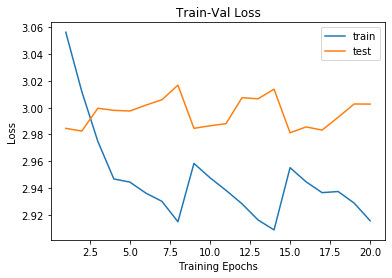

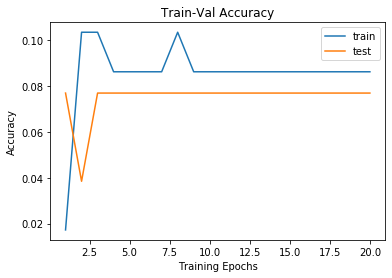

In [25]:
trainutils.plot_loss(loss_hist, metric_hist)